In [1]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import netcomp as nc
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import mean_squared_error
import pycombo
# from netAPI import visualizePartitionShape
# from netAPI import getComboPartition
# from netAPI import getComboSeries
import geopandas as gpd
import matplotlib.pyplot as plt

## Community detection

In [2]:
def makeGraphfromDf(df,oCol, dCol, weight):
    G=nx.DiGraph()
    nx.set_edge_attributes(G,'weight', 0)
    for k in df.index:
        G.add_edge(df[oCol][k],df[dCol][k],weight=df[weight][k])
#     nx.write_edgelist(G, comboPath+'temp/%s.net'%city)
    return G

In [3]:
def reClass(commDict):
    label, index = np.unique(np.fromiter(commDict.values(),dtype=int), return_index=True)
    recommDict = {}
    for zone in commDict.keys():
        recommDict[zone] = recommDict[commDict[zone]]
    return reClass

In [4]:
def fixedARI(group1, group2):
    from sklearn.metrics import pair_confusion_matrix

    (tn, fp), (fn, tp) = pair_confusion_matrix(group1, group2)
    (tn, fp), (fn, tp) = (float(tn), float(fp)), (float(fn), float(tp))
    if fn == 0 and fp == 0:
        return 1.0

    return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
                                           (tp + fp) * (fp + tn))

In [5]:
def weightedAdjustedRandIndex(df,oCol, dCol,groundTruthCol, predCol,maxcom):
    GTruth = makeGraphfromDf(df,oCol, dCol, groundTruthCol)
    GPred = makeGraphfromDf(df,oCol, dCol, predCol)
    population = df.groupby(['origin']).agg({'flowReal':'sum'}).reset_index()
#     population['flowReal'] = population['flowReal']/population['flowReal'].sum()
#     population['flowReal'] = round(population['flowReal'],2)*100
    population['flowReal'] = population['flowReal'].astype(int)
    groundTruthComm,groundTruthMod = pycombo.execute(GTruth, max_communities = maxcom)
    
    predictComm,predictMod = pycombo.execute(GPred, max_communities = maxcom)
    weight = dict(zip(population.origin, population.flowReal))
#     print(population)
    groundTruthCommWeighted = []
    predictCommWeighted = []
    for zone in sorted(groundTruthComm.keys()):
        if zone in weight:
            groundTruthCommWeighted += [groundTruthComm[zone]]*weight[zone]
            predictCommWeighted += [predictComm[zone]]*weight[zone]

        else:
            pass
    groundTruthCommWeighted = np.array(groundTruthCommWeighted, dtype=np.float64)
    predictCommWeighted = np.array(predictCommWeighted, dtype=np.float64)
#     ri = rand_score(groundTruthCommWeighted,predictCommWeighted)
    mse = mean_squared_error(df[groundTruthCol],df[predCol])
    ari = fixedARI(groundTruthCommWeighted,predictCommWeighted)
    nmi = normalized_mutual_info_score(groundTruthCommWeighted,predictCommWeighted)
#     countCommGT,countCommPr = len(set(groundTruthComm.values())),len(set(predictComm.values()))
#     return (ri,ari,nmi,countCommGT,countCommPr)
    return(mse,ari,nmi)

In [6]:
def plotMetrics(cities,resultList,modelList,metricLoc=0):
    modelAmount = len(modelList)
    metric = {0:'RI',1:'ARI',2:'NMI'}
    metricName = metric[metricLoc]

    x = np.arange(len(cities))  # the label locations
    width = 0.2  # the width of the bars
    
    if modelAmount % 2 == 0:
        shift = width*0.5
    else:
        shift = 0
    
    fig, ax = plt.subplots(figsize=(16,8))
    
    for i in range(modelAmount):
        plt.bar(x-(modelAmount-1)/2*width+i*width,
                np.array(list(resultList[i].values()))[:,metricLoc],width=width,
                label=modelList[i])


   
    # plt.title('Adjusted rand score')

   
    
    _ = plt.xticks(ticks=x,labels=cities,rotation=70)
    plt.legend(loc='best',bbox_to_anchor=(0.5, 0., 0.5, 0.5))
#     plt.title('%s comparison between noconstrain and doubly constrain gravity model for income groups'%metricName)

In [7]:
cities = ['New York City',
    'Los Angeles',
    'Chicago',
    'Houston',
    'Boston',
    'Phoenix',
    'Philadelphia',
    'San Antonio',
    'San Diego', 
    'Dallas', 
    'San Jose', 
    'Austin']

In [23]:
seed = 2017
np.random.seed(seed)
NoconstrainPowerLaw = {}
NoconstrainFullPowerLaw = {}
NoconstrainExp = {}
constrainDist = {}
classicConstrainDist = {}
# cities = ['New York City', 'Los Angeles', 'Chicago', 'Houston', 'Boston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose', 'Austin']
for city in cities:
    print(city)
    total = pd.read_csv('../unconstrainPowerlawPredictionResultsCT/%s.csv'%city)
    total['flowPred'] = total['S000pred']
    total['flowReal'] = total['S000']
    total = total.groupby(['origin','destination']).sum().reset_index()
    mse,ari,nmi = weightedAdjustedRandIndex(total,'origin','destination','flowReal','flowPred',0)
    NoconstrainPowerLaw[city] = [mse,ari,nmi]

    total = pd.read_csv('../unconstrainFullPowerlawPredictionResultsCT/%s.csv'%city)
    total['flowPred'] = total['S000pred']
    total['flowReal'] = total['S000']
    total = total.groupby(['origin','destination']).sum().reset_index()
    mse,ari,nmi = weightedAdjustedRandIndex(total,'origin','destination','flowReal','flowPred',0)
    NoconstrainFullPowerLaw[city] = [mse,ari,nmi]
    
#     total = pd.read_csv('../unconstrainExpPredictionResultsCT/%s.csv'%city)
#     total['flowPred'] = total['S000pred']
#     total['flowReal'] = total['S000']
#     total = total.groupby(['origin','destination']).sum().reset_index()
#     mse,ari,nmi = weightedAdjustedRandIndex(total,'origin','destination','flowReal','flowPred',0)
#     NoconstrainExp[city] = [mse,ari,nmi]
    
    total = pd.read_csv('../constrainCTdistbinsNonlog/%s.csv'%city)
    total['flowReal'] = total['S000']
    total = total.groupby(['origin','destination']).sum().reset_index()
    mse,ari,nmi = weightedAdjustedRandIndex(total,'origin','destination','flowReal','flowPred',0)
    constrainDist[city] = [mse,ari,nmi]
    
    total = pd.read_csv('../constrainCTdistbinsAB/%s.csv'%city)
    total['flowReal'] = total['S000']
    total = total.groupby(['origin','destination']).sum().reset_index()
    mse,ari,nmi = weightedAdjustedRandIndex(total,'origin','destination','flowReal','flowPred',0)
    classicConstrainDist[city] = [mse,ari,nmi]

New York City
Los Angeles
Chicago
Houston
Boston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin


In [10]:
total = pd.read_csv('../constrainCTdistbinsAB/%s.csv'%city)
total
# total['flowReal'] = total['S000']
# total = total.groupby(['origin','destination']).sum().reset_index()
# mse,ari,nmi = weightedAdjustedRandIndex(total,'origin','destination','flowReal','flowPred',0)
# classicConstrainDist[city] = [mse,ari,nmi]

,origin,destination,S000,flowPred
0,48453000101,48453000101,64,0.000686
1,48453000101,48453000102,11,0.000234
2,48453000101,48453000203,31,0.001742
3,48453000101,48453000204,60,0.002161
4,48453000101,48453000205,6,0.000424
...,...,...,...,...
34772,48453980000,48453002310,1,0.000021
34773,48453980000,48453002411,2,0.000099
34774,48453980000,48453002421,3,0.000032
34775,48453980000,48453002432,2,0.000016


In [20]:
total = pd.read_csv('../constrainCTdistbinsAB/%s.csv'%city)
total

,origin,destination,S000,S000A,S000B,S000f(d),S000flowPred
0,36005009800,36005001600,11,1.474893,2.031442,7.798498e-07,4.450383
1,36081157101,36081157101,48,1.544131,7.202672,7.798498e-07,6.452413
2,36047051002,36047081800,1,1.194328,6.220005,7.798498e-07,2.968047
3,36061019300,36061016001,8,1.097078,1.253760,7.798498e-07,8.222659
4,36047053500,36047055100,4,1.631043,1.888823,7.798498e-07,2.621005
...,...,...,...,...,...,...,...
976827,36081054200,36047029400,1,1.552385,2.049159,1.908827e-07,1.332713
976828,36005009800,36047062800,1,1.474893,3.180338,1.908827e-07,1.057070
976829,36005012901,36047028200,1,1.490340,2.890068,1.908827e-07,0.651689
976830,36081162100,36047030400,1,1.539564,2.008360,1.908827e-07,1.193415


In [26]:
df = pd.DataFrame(index=cities)
df['A1'] = np.array(list(NoconstrainPowerLaw.values()))[:,0]
# df['A2'] = np.array(list(NoconstrainExp.values()))[:,0]
df['A3'] = np.array(list(NoconstrainFullPowerLaw.values()))[:,0]

df['D'] = np.array(list(constrainDist.values()))[:,0]
df['E'] = np.array(list(classicConstrainDist.values()))[:,0]
df

,A1,A3,D,E
New York City,20.423988,19.606444,58.004333,20.406016
Los Angeles,25.987321,21.230966,55.846232,22.270675
Chicago,60.418562,58.261018,296.160485,58.960871
Houston,77.334495,72.549557,235.513805,68.142577
Boston,103.516987,94.413325,330.867465,88.309398
Phoenix,36.378563,35.071937,122.296936,31.243984
Philadelphia,42.658918,41.752102,199.394737,41.228779
San Antonio,64.677219,61.690203,297.780763,56.888626
San Diego,94.990141,88.272657,344.736338,73.015507
Dallas,57.138951,54.892353,241.494201,49.990746


In [21]:
total = pd.read_csv('../constrainCTdistbinsAB/%s.csv'%city)
total['flowReal'] = total['S000']
total = total.groupby(['origin','destination']).sum().reset_index()
mse,ari,nmi = weightedAdjustedRandIndex(total,'origin','destination','flowReal','flowPred',0)
classicConstrainDist[city] = [mse,ari,nmi]

In [22]:
mse

20.40601619139391

In [36]:
total

,origin,destination,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,distance,jobs,residence,flowPred
0,36005000100,36005003300,1,0,1,0,0.1,0.1,1.0,0,0,1,2.944260,316,872,1.742516
1,36005000100,36005006900,1,0,1,0,0.1,0.1,1.0,0,0,1,4.222041,672,872,1.587393
2,36005000100,36005009300,1,0,0,1,0.1,0.1,1.0,0,0,1,1.455214,9314,872,17.705676
3,36005000100,36005009800,1,0,1,0,1.0,0.1,0.1,0,1,0,4.634619,381,872,1.728679
4,36005000100,36005011800,1,0,1,0,0.1,0.1,1.0,0,0,1,7.439422,651,872,1.743276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976827,36081024600,36081003600,1,1,0,0,0.1,0.1,1.0,0,0,1,5.442283,74,67,0.379779
976828,36081024600,36081066900,1,0,1,0,0.1,0.1,1.0,0,0,1,7.936649,73,67,0.331181
976829,36005011000,36081046500,1,0,1,0,0.1,0.1,1.0,0,0,1,8.207498,505,3,1.037880
976830,36005011000,36005011502,1,0,1,0,0.1,0.1,1.0,0,1,0,4.591369,689,3,1.346390


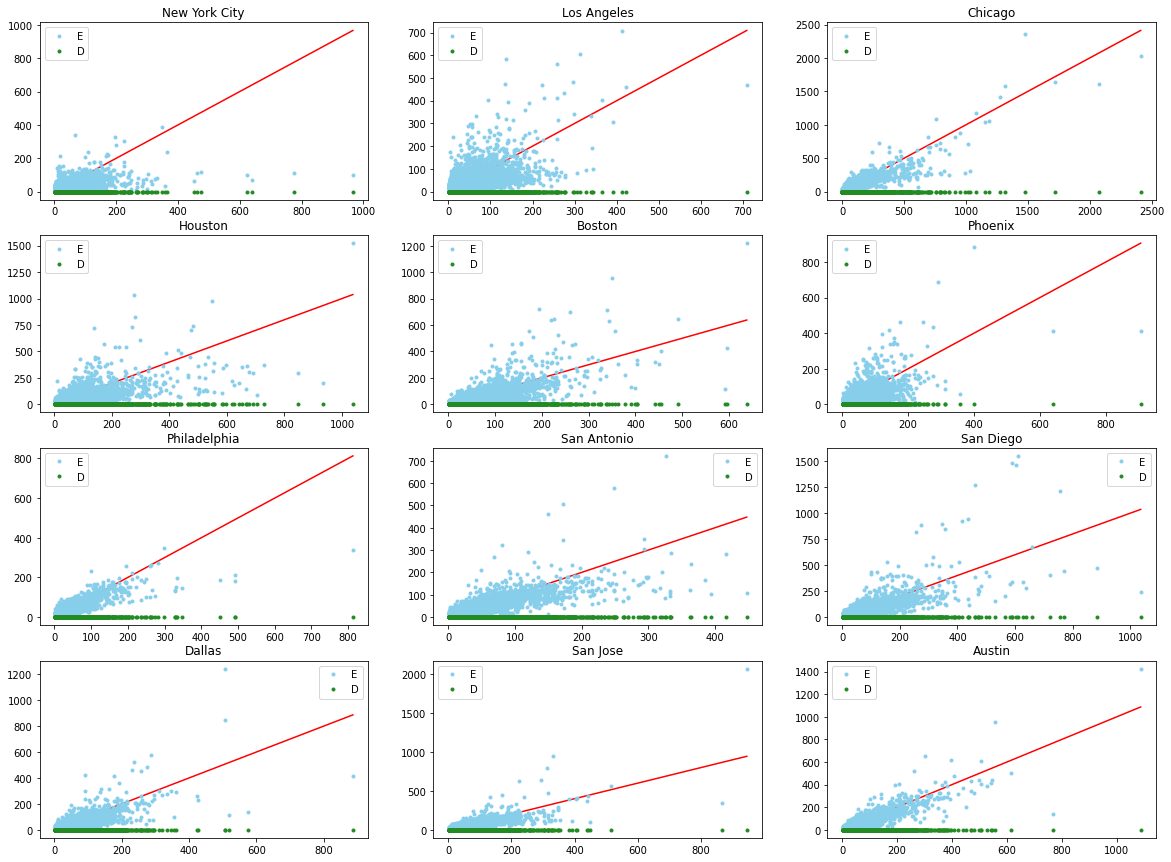

In [42]:
fig, ax = plt.subplots(4,3,figsize=(20,15))
for i,city in enumerate(cities):
#     print(city)
    total = pd.read_csv('../unconstrainPowerlawPredictionResultsCT/%s.csv'%city)
    total['flowPred'] = total['S000pred']
    total['flowReal'] = total['S000']
    total = total.groupby(['origin','destination']).sum().reset_index()
#     ax[i//3,i%3].plot(total.flowReal,total.flowPred,'.',color='k', label='real')
#     ax[i//3,i%3].plot(total.flowReal,total.flowPred,'.',color='gold', label='A1')
    x = [0,max(total.flowReal)]
    y = [0,max(total.flowReal)]
    ax[i//3,i%3].plot(x,y,'red')
#     total = pd.read_csv('../unconstrainFullPowerlawPredictionResultsCT/%s.csv'%city)
#     total['flowPred'] = total['S000pred']
#     total['flowReal'] = total['S000']
#     total = total.groupby(['origin','destination']).sum().reset_index()
#     ax[i//3,i%3].plot(total.flowReal,total.flowPred,'.',color='deeppink', label='A3',)

    
    total = pd.read_csv('../classicDoublyConstrained/%s.csv'%city)
#     total['flowPred'] = total['S000pred']
    total['flowReal'] = total['S000']
    total = total.groupby(['origin','destination']).sum().reset_index()
    ax[i//3,i%3].plot(total.flowReal,total.flowPred,'.',color='skyblue', label='E')
    
    total = pd.read_csv('../constrainCTdistbinsNonlog/%s.csv'%city)
    total['flowReal'] = total['S000']
    total = total.groupby(['origin','destination']).sum().reset_index()
    ax[i//3,i%3].plot(total.flowReal,total.flowPred,'.',color='forestgreen', label='D')
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_title(city)


In [43]:
total = pd.read_csv('../constrainCTdistbinsNonlog/%s.csv'%city)
total

,origin,destination,S000,flowPred
0,48453000101,48453000101,64,0.000686
1,48453000101,48453000102,11,0.000234
2,48453000101,48453000203,31,0.001742
3,48453000101,48453000204,60,0.002161
4,48453000101,48453000205,6,0.000424
...,...,...,...,...
34772,48453980000,48453002310,1,0.000021
34773,48453980000,48453002411,2,0.000099
34774,48453980000,48453002421,3,0.000032
34775,48453980000,48453002432,2,0.000016


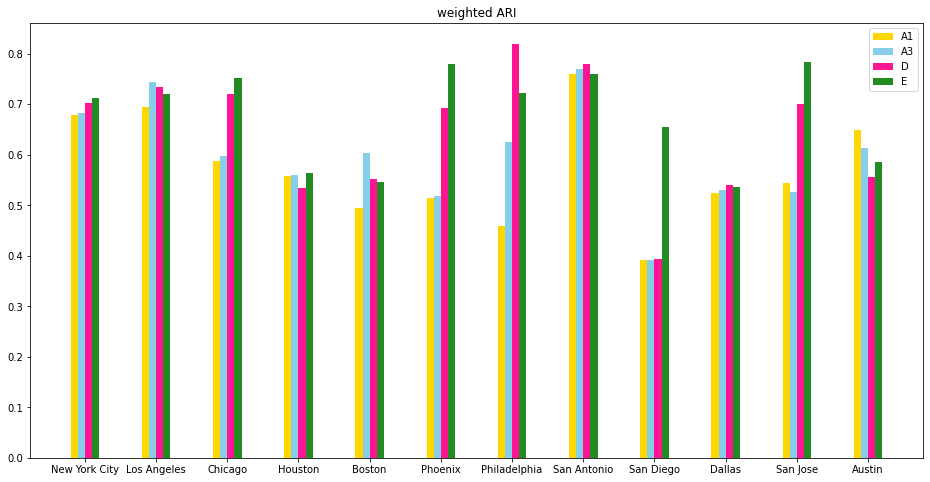

In [34]:
x = np.arange(len(cities))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(16,8))


plt.bar(x-width*1.5,np.array(list(NoconstrainPowerLaw.values()))[:,1],
        width=width,color=['gold']*len(cities), label='A1')


plt.bar(x-width*.5,np.array(list(NoconstrainFullPowerLaw.values()))[:,1],
        width=width,color=['skyblue']*len(cities), label='A3')

plt.bar(x+width*.5,np.array(list(constrainDist.values()))[:,1],
        width=width,color=['deeppink']*len(cities), label='D')

plt.bar(x+width*1.5,np.array(list(classicConstrainDist.values()))[:,1],
        width=width,color=['forestgreen']*len(cities), label='E')

# plt.hlines(0.67,xmin=0,xmax=12,color='r')
_ = plt.xticks(ticks=x,labels=cities)
plt.title('weighted ARI')
plt.legend()

In [33]:
df = pd.DataFrame(index=cities)
df['A1'] = np.array(list(NoconstrainPowerLaw.values()))[:,1]
# df['A2'] = np.array(list(NoconstrainExp.values()))[:,0]
df['A3'] = np.array(list(NoconstrainFullPowerLaw.values()))[:,1]

df['D'] = np.array(list(constrainDist.values()))[:,1]
df['E'] = np.array(list(classicConstrainDist.values()))[:,1]
df

,A1,A3,D,E
New York City,0.677921,0.681880,0.701702,0.711368
Los Angeles,0.695059,0.743339,0.733809,0.720251
Chicago,0.586876,0.597689,0.719657,0.751498
Houston,0.557563,0.560524,0.533265,0.563337
Boston,0.494461,0.603502,0.552618,0.546121
Phoenix,0.515062,0.518159,0.692341,0.780353
Philadelphia,0.458170,0.624881,0.819932,0.723180
San Antonio,0.760264,0.770186,0.779266,0.760264
San Diego,0.391636,0.392019,0.392615,0.655587
Dallas,0.523656,0.531065,0.539230,0.536710


In [26]:
seed = 2017
np.random.seed(seed)
NoconstrainPowerLaw = {}
NoconstrainFullPowerLaw = {}
NoconstrainExp = {}
constrainDist = {}
constrainDistTotal = {}
# cities = ['New York City', 'Los Angeles', 'Chicago', 'Houston', 'Boston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose', 'Austin']
for city in cities:
    print(city)
    total = pd.read_csv('../unconstrainPowerlawPredictionResultsCTIncome/%s.csv'%city)
    total['flowPred'] = total['SE01pred'] + total['SE02pred'] + total['SE03pred']
    total['flowReal'] = total['S000']
    total = total.groupby(['origin','destination']).sum().reset_index()
    mse,ari,nmi = weightedAdjustedRandIndex(total,'origin','destination','flowReal','flowPred',0)
    NoconstrainPowerLaw[city] = [mse,ari,nmi]

    total = pd.read_csv('../unconstrainFullPowerlawPredictionResultsCTIncome//%s.csv'%city)
    total['flowPred'] = total['SE01pred'] + total['SE02pred'] + total['SE03pred']
    total['flowReal'] = total['S000']
    total = total.groupby(['origin','destination']).sum().reset_index()
    mse,ari,nmi = weightedAdjustedRandIndex(total,'origin','destination','flowReal','flowPred',0)
    NoconstrainFullPowerLaw[city] = [mse,ari,nmi]
    
    total = pd.read_csv('../unconstrainExpPredictionResultsCTIncome/%s.csv'%city)
    total['flowPred'] = total['SE01pred'] + total['SE02pred'] + total['SE03pred']
    total['flowReal'] = total['S000']
    total = total.groupby(['origin','destination']).sum().reset_index()
    mse,ari,nmi = weightedAdjustedRandIndex(total,'origin','destination','flowReal','flowPred',0)
    NoconstrainExp[city] = [mse,ari,nmi]
    
    total = pd.read_csv('../constrainCTdistbinsIncomeIncome/%s.csv'%city)
    total['flowReal'] = total['S000']
    total = total.groupby(['origin','destination']).sum().reset_index()
    mse,ari,nmi = weightedAdjustedRandIndex(total,'origin','destination','flowReal','flowPred',0)
    constrainDist[city] = [mse,ari,nmi]
    
    total = pd.read_csv('../constrainCTdistbinsIncomeTotal/%s.csv'%city)
    total['flowReal'] = total['S000']
    total = total.groupby(['origin','destination']).sum().reset_index()
    mse,ari,nmi = weightedAdjustedRandIndex(total,'origin','destination','flowReal','flowPred',0)
    constrainDistTotal[city] = [mse,ari,nmi]

New York City
Los Angeles
Chicago
Houston
Boston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin


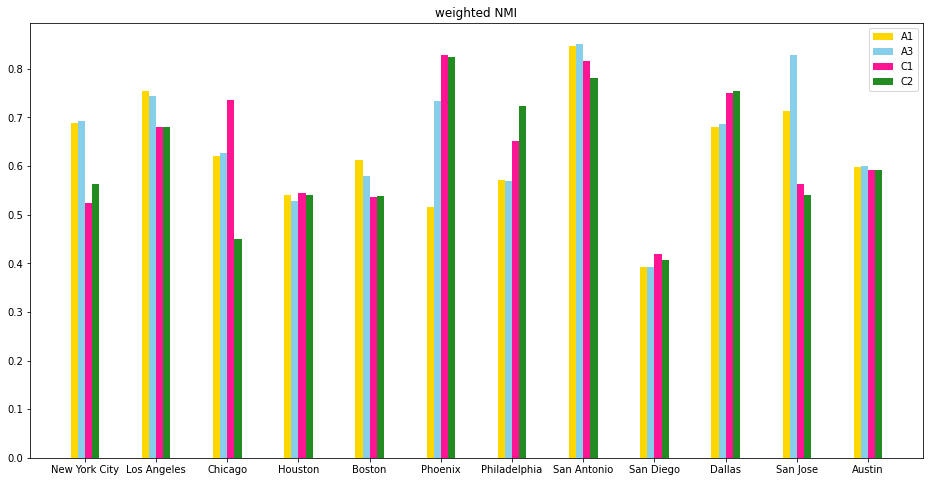

In [31]:
x = np.arange(len(cities))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(16,8))


plt.bar(x-width*1.5,np.array(list(NoconstrainPowerLaw.values()))[:,1],
        width=width,color=['gold']*len(cities), label='A1')


plt.bar(x-width*0.5,np.array(list(NoconstrainFullPowerLaw.values()))[:,1],
        width=width,color=['skyblue']*len(cities), label='A3')

plt.bar(x+width*0.5,np.array(list(constrainDistTotal.values()))[:,1],
        width=width,color=['deeppink']*len(cities), label='C1')
plt.bar(x+width*1.5,np.array(list(constrainDist.values()))[:,1],
        width=width,color=['forestgreen']*len(cities), label='C2')

# plt.hlines(0.57,xmin=0,xmax=12,color='r')
_ = plt.xticks(ticks=x,labels=cities)
plt.title('weighted NMI')
plt.legend()

,A1,A3,C1,C2
New York City,18.907977,18.139498,501.674400,491.654884
Los Angeles,23.324360,20.260237,464.970749,462.803360
Chicago,53.949213,49.265767,2535.008337,2542.257216
Houston,72.660339,68.642706,1943.244227,1947.269918
Boston,96.302125,87.816136,2417.653733,2477.872232
Phoenix,35.028094,33.788239,977.101946,974.544913
Philadelphia,37.295098,35.244595,1645.920967,1625.413462
San Antonio,56.602223,52.174814,2314.492194,2306.918492
San Diego,88.383423,81.347714,2824.281949,2832.859707
Dallas,54.620124,52.518758,1811.189260,1817.633347


In [31]:
df = pd.DataFrame(index=cities)
df['A1'] = np.array(list(NoconstrainPowerLaw.values()))[:,1]
# df['A2'] = np.array(list(NoconstrainExp.values()))[:,0]
df['A3'] = np.array(list(NoconstrainFullPowerLaw.values()))[:,1]

df['D'] = np.array(list(constrainDist.values()))[:,1]
df['E'] = np.array(list(classicConstrainDist.values()))[:,1]
df

,A1,A3,D,E
New York City,0.677921,0.681880,0.701702,0.711368
Los Angeles,0.695059,0.743339,0.733809,0.720251
Chicago,0.586876,0.597689,0.719657,0.751498
Houston,0.557563,0.560524,0.533265,0.563337
Boston,0.494461,0.603502,0.552618,0.546121
Phoenix,0.515062,0.518159,0.692341,0.780353
Philadelphia,0.458170,0.624881,0.819932,0.723180
San Antonio,0.760264,0.770186,0.779266,0.760264
San Diego,0.391636,0.392019,0.392615,0.655587
Dallas,0.523656,0.531065,0.539230,0.536710


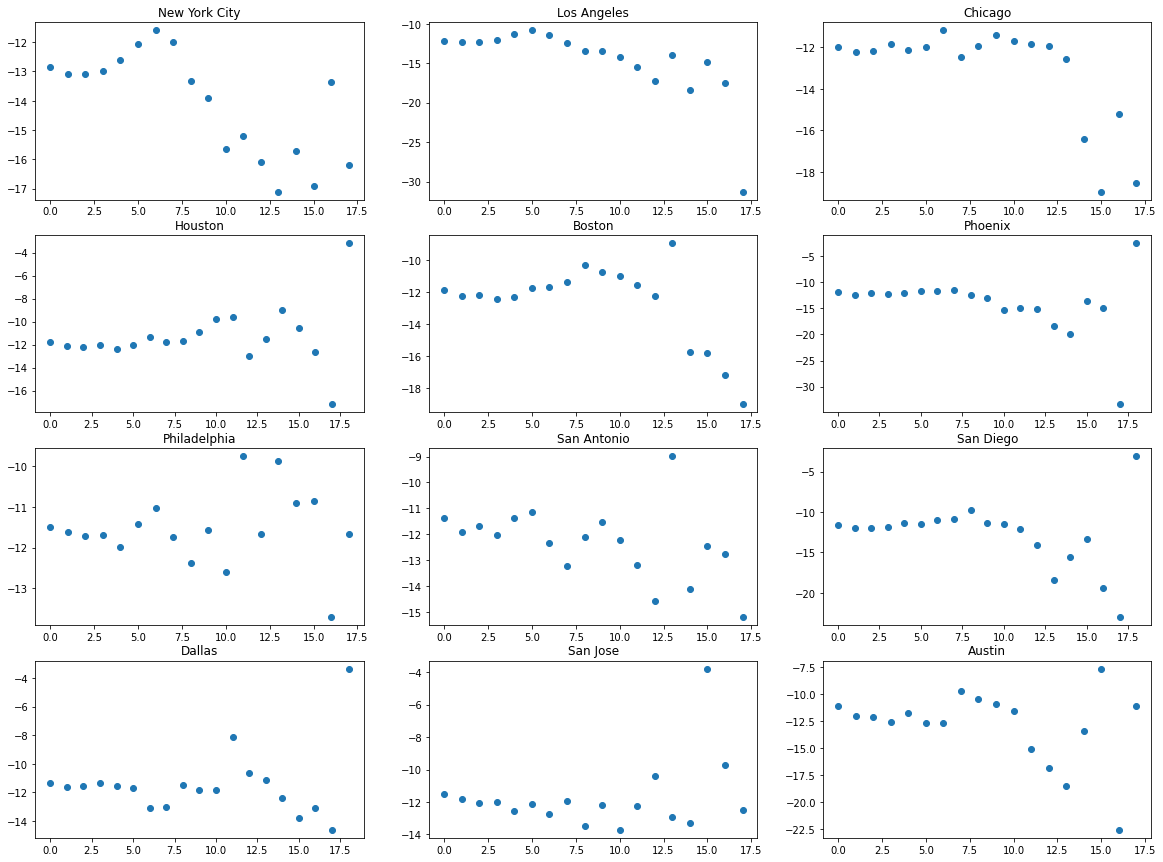

In [11]:
fig, ax = plt.subplots(4,3,figsize=(20,15))
for i,city in enumerate(cities):
    df = pd.read_csv('../unconstrainPredictionResultsCTDist/%sfrecords.csv'%(city))
    ax[i//3,i%3].plot(df['distance groups'],df['f'],'o')
    ax[i//3,i%3].set_title(city)

In [10]:
len(cities)

12